<h1>Customer Analysis Round 7</h1>

Remember the previous rounds. Follow the steps as shown in previous lectures and try to improve the accuracy of the model. Include both categorical columns in the exercise. Some approaches you can try in this exercise:

- use the concept of multicollinearity and remove insignificant variables
- use a different method of scaling the numerical variables
- use a different ratio of train test split
- use the transformation on numerical columns which align it more towards a normal distribution

Get the data
- We are using the marketing_customer_analysis.csv file.

Dealing with the data
 - Already done in rounds 2 to 7.
 - Bonus: Build a function, from round 2 and round 7, to clean and process the data.


Explore the data

- Done in the round 3.


Modeling

- Try to improve the linear regression model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('marketing_customer_analysis.csv')
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
# Function for data cleaning

def clean_data(data):
    data_cleaned = data.copy()

# Standardizing header names: 
# 1) Converting names to lowercase and
# 2) Removing underscores '_'

    cols = []
    for col in data_cleaned.columns:
        cols.append(col.lower().replace(' ', '_'))
    data_cleaned.columns = cols

# Deleting duplicates

    data_cleaned = data_cleaned.drop_duplicates()
    
# Filling all missing values of all numeric columns with their mean value
    
    for col in data_cleaned.select_dtypes(include=np.number).columns:
        data_cleaned[col] = data_cleaned[col].fillna(np.mean(data_cleaned[col]))

# Filling all missing values of all categorical columns with their mode value
    for col in data_cleaned.select_dtypes(include=['object']).columns:
        data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode())
        
# Reset row labels
    data_cleaned = data_cleaned.reset_index(drop=True)
    
    return data_cleaned
        

In [4]:
# Function for data filtering

def filter_data(data):
    
    # Extracting the months from the date to separate column
    # Filtering the data (we need only the first 3 months)
    data['month'] = pd.to_datetime(data['effective_to_date']).dt.month
    data = data[ (data['month']==1) | (data['month']==2) | (data['month']==3) ]
    
    return data

In [5]:
# Function for data exploring

def explore_data(data):

    # Data description and info
    data.info()
    data.describe()
    
    # Histogram with total number of responses
    plt.figure()
    data['response'].hist()

    
    # Piechart: response rate by the sales channel
    plt.figure()
    sales_channels = []
    for label in data['sales_channel'].unique():
        sales_channels.append((data[data['sales_channel'] == label]['response'] == 'Yes').mean() * 100)
    labels = list(data['sales_channel'].unique())
    #define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:5]
    #create pie chart
    plt.pie(sales_channels, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()
    
    # Showing a plot of the response rate by total claim amount and by income
    plt.figure()
    data.groupby('response')['total_claim_amount'].hist()
    plt.figure()
    sns.histplot(data, x='total_claim_amount', hue='response')
    plt.figure()
    data.groupby('response')['income'].hist()
    plt.figure()
    sns.histplot(data, x='income', hue='response')
    
    # Checking numerical and categoracal columns of the dataframe
    numerical = data.select_dtypes(np.number)
    categorical = data.select_dtypes(object)
    numerical.head()
    categorical.head()

    # Checking the normality of the numerical columns
    for column_name in numerical.columns:
        plt.figure()
        sns.displot(numerical[column_name], kde=True)
    
    # Showing histograms for the numerical columns
    for column_name in numerical.columns:
        plt.figure()
        plt.hist(numerical[column_name], bins=30)
        plt.show()  
        

    # Use Matplotlib to construct histograms
    plt.style.context('ggplot')    
    for column_name in numerical.columns:
        plt.figure()
        fig,ax = plt.subplots()
        ax.set_title(column_name)
        plt.hist(numerical[column_name], bins=20)
        plt.show()
    
    # Checking the correlation
    numerical.corr()
    sns.heatmap(numerical.corr())
    
    return data

In [6]:
# Function for data processing

def process_data(data):

    # X-y split
    y = data['total_claim_amount']
    X = data.drop(['total_claim_amount'], axis=1)
    print('X.shape:',X.shape)
    print('X.shape:',X.shape)
    
    # Spliting X into numerical and categorial columns
    X_num = X.select_dtypes(np.number)
    X_cat = X.select_dtypes(object)

    # Using the MinMaxScaler to normalize X_num
    # This will scale all within a range from 0.0 to 1.0.
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(X_num)
    X_normalized = minMaxScaler.transform(X_num)
    X_normalized_data = pd.DataFrame(X_normalized, columns=X_num.columns)
    display(X_normalized_data)
    print('X_normalized.shape', X_normalized.shape)
    
    # Using standard scaler: making data distributed with mean=0 and std=1
#     stdScaler = StandardScaler()
#     stdScaler.fit(X_num)
#     X_standardized = stdScaler.transform(X_num)
    
#     print('X_standardized.shape', X_standardized.shape)
#     pd.DataFrame(X_standardized, columns=X_num.columns)
    
    
    # Deleting column 'customer' and 'effective_to_date'
    X_cat_to_encode = X_cat.drop(['customer','effective_to_date'], axis=1)
    X_cat_to_encode.columns.tolist()
    
    display(X_normalized_data.corr())

    # Using OneHot Encoder - it is converting categorial columns into multiple numerical columns
    encoder = OneHotEncoder()
    encoder.fit(X_cat_to_encode)
    encoded = encoder.transform(X_cat_to_encode).toarray()
    onehot_encoded_data = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
    onehot_encoded_data.head()

    # Concatenating normalized numerical columns with one-hot-encoded columns
    X = pd.concat([X_normalized_data, onehot_encoded_data], axis=1)

    return X,y


In [7]:
# Function for model training and validating

# Here we use 20% of the data for testing and RNG-seed = 42

def train_and_validate_model(X, y, test_size=0.2, random_state=42):
    
    # Spliting X,y into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)
    
    # Applying linear regression, train/fit the model
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    
    # Predicting training set
    y_pred_train = lm.predict(X_train)
    print('y_pred_train =', y_pred_train)

    # R2 score for training set
    r2_train = r2_score(y_train, y_pred_train)
    print('r2_train =', r2_train)

    # Predict test set
    y_pred_test  = lm.predict(X_test)
    print('y_pred_test =', y_pred_test)

    # R2 score for test set
    r2_test = r2_score(y_test, y_pred_test)
    print('r2_test =', r2_test)

    # MSE - Mean Squared Error
    mse = mean_squared_error(y_test,y_pred_test)
    print('MSE =', mse)

    # RMSE - Root Mean Squared Error
    rmse = np.sqrt(mse)
    print('RMSE =', rmse)

    # MAE - Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred_test)
    print('MAE =', mae)
    

<h2>Now we can use these functions: </h2>

In [8]:
data = clean_data(data)
data.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [9]:
data = filter_data(data)
data.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,month
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,2
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,1
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,2
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,1
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9134 entries, 0 to 9133
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer                       9134 non-null   object 
 1   state                          9134 non-null   object 
 2   customer_lifetime_value        9134 non-null   float64
 3   response                       9134 non-null   object 
 4   coverage                       9134 non-null   object 
 5   education                      9134 non-null   object 
 6   effective_to_date              9134 non-null   object 
 7   employmentstatus               9134 non-null   object 
 8   gender                         9134 non-null   object 
 9   income                         9134 non-null   int64  
 10  location_code                  9134 non-null   object 
 11  marital_status                 9134 non-null   object 
 12  monthly_premium_auto           9134 non-null   i

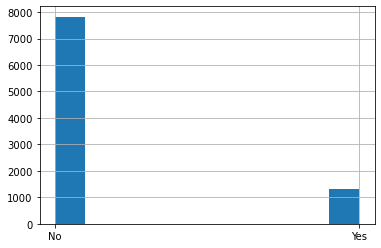

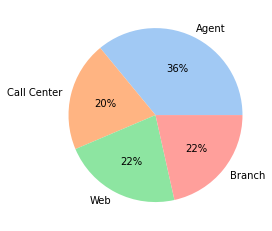

/var/folders/_x/417nh66n2m9gh2skyd2l26340000gn/T/ipykernel_18961/2453375634.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


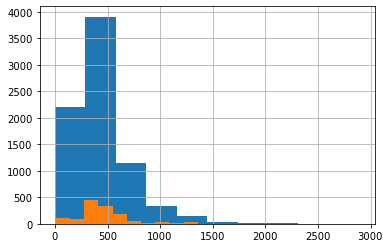

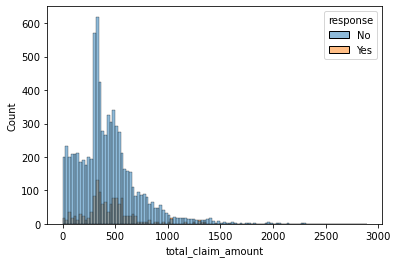

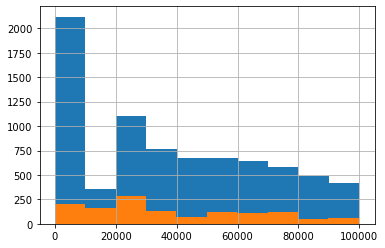

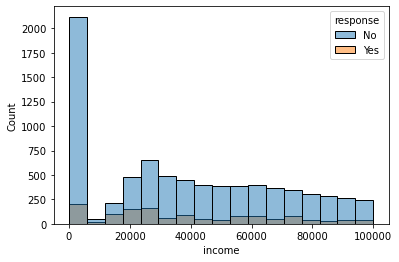

<Figure size 432x288 with 0 Axes>

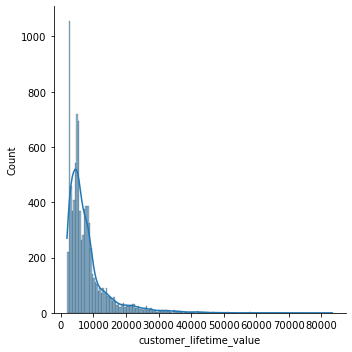

<Figure size 432x288 with 0 Axes>

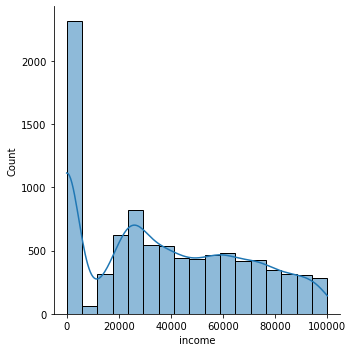

<Figure size 432x288 with 0 Axes>

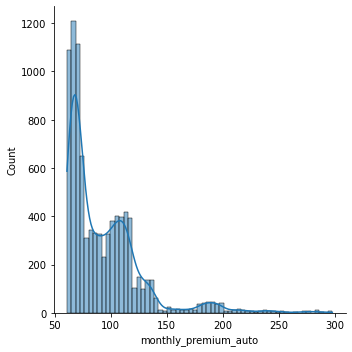

<Figure size 432x288 with 0 Axes>

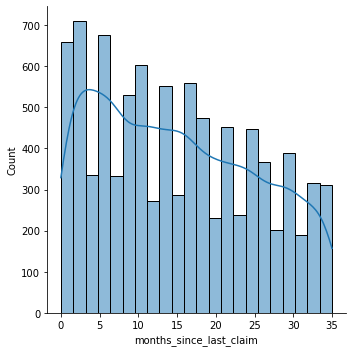

<Figure size 432x288 with 0 Axes>

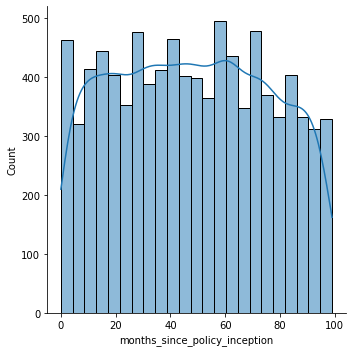

<Figure size 432x288 with 0 Axes>

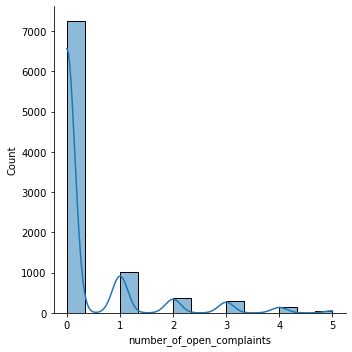

<Figure size 432x288 with 0 Axes>

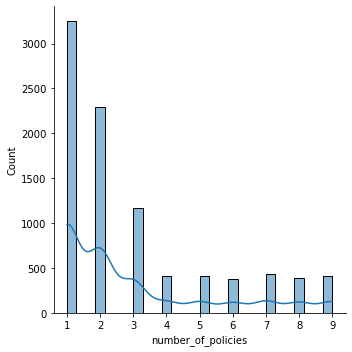

<Figure size 432x288 with 0 Axes>

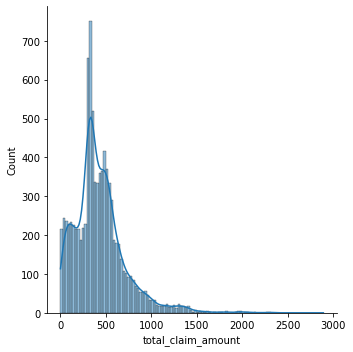

<Figure size 432x288 with 0 Axes>

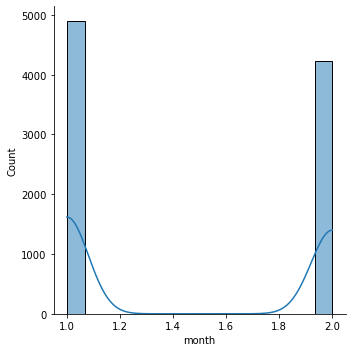

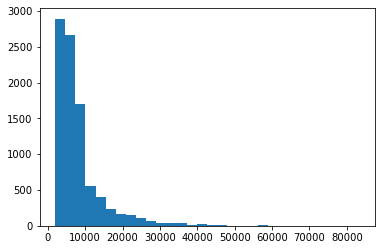

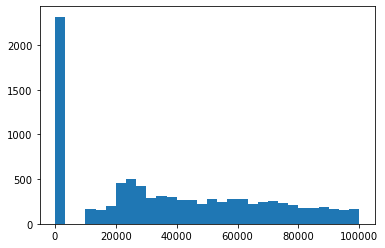

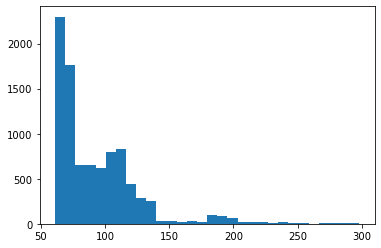

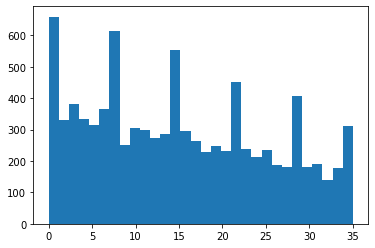

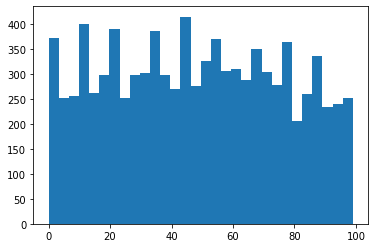

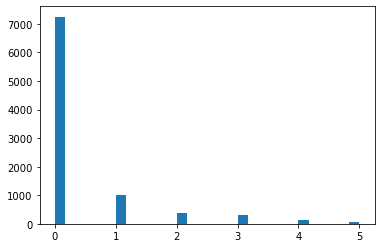

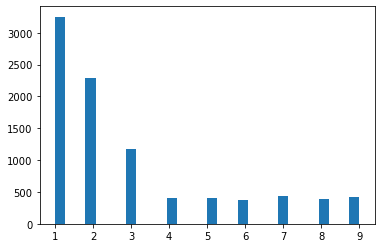

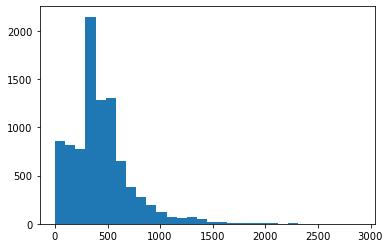

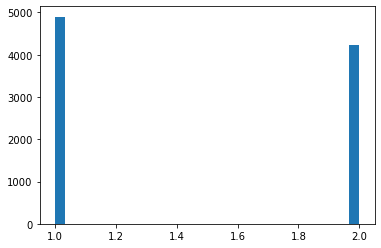

<Figure size 432x288 with 0 Axes>

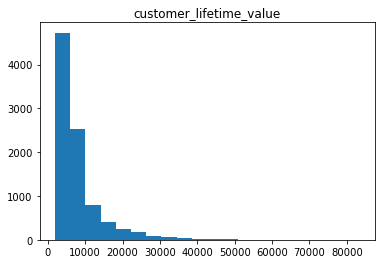

<Figure size 432x288 with 0 Axes>

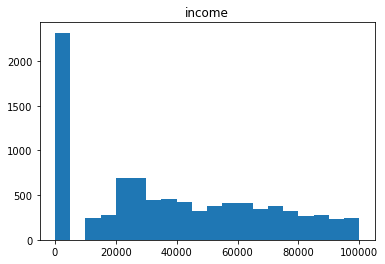

<Figure size 432x288 with 0 Axes>

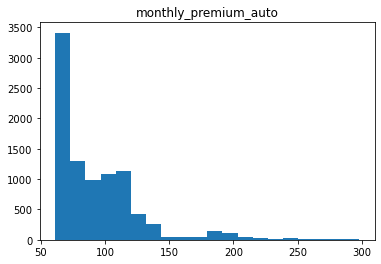

<Figure size 432x288 with 0 Axes>

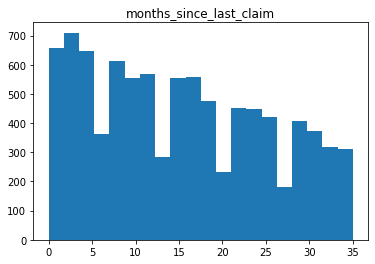

<Figure size 432x288 with 0 Axes>

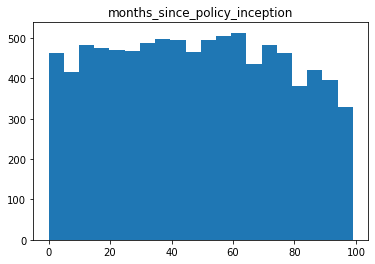

<Figure size 432x288 with 0 Axes>

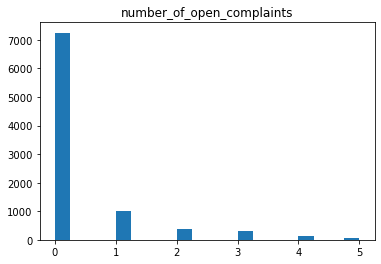

<Figure size 432x288 with 0 Axes>

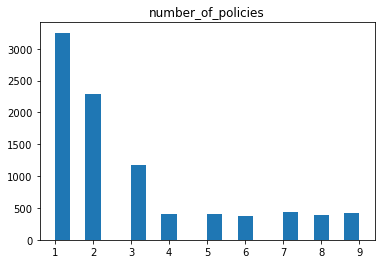

<Figure size 432x288 with 0 Axes>

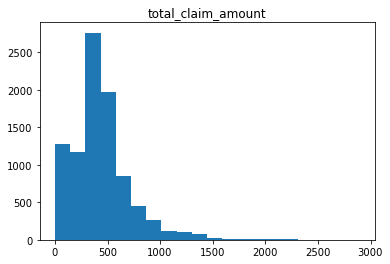

<Figure size 432x288 with 0 Axes>

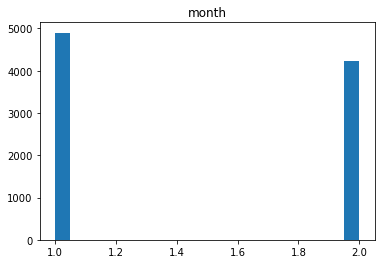

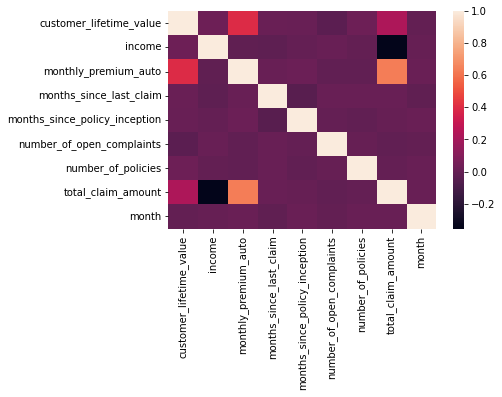

In [10]:
data = explore_data(data)

In [11]:
X,y = process_data(data)

X.shape: (9134, 24)
X.shape: (9134, 24)


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,month
0,0.010629,0.562847,0.033755,0.914286,0.050505,0.0,0.000,1.0
1,0.062406,0.000000,0.139241,0.371429,0.424242,0.0,0.875,0.0
2,0.134960,0.487763,0.198312,0.514286,0.383838,0.0,0.125,1.0
3,0.070589,0.000000,0.189873,0.514286,0.656566,0.0,0.750,0.0
4,0.011245,0.438443,0.050633,0.342857,0.444444,0.0,0.000,1.0
...,...,...,...,...,...,...,...,...
9129,0.264137,0.719547,0.050633,0.514286,0.898990,0.0,0.125,1.0
9130,0.014719,0.216081,0.075949,0.400000,0.282828,0.0,0.000,1.0
9131,0.076951,0.000000,0.101266,0.257143,0.373737,0.6,0.125,1.0
9132,0.069098,0.219452,0.147679,0.971429,0.030303,0.0,0.250,1.0


X_normalized.shape (9134, 8)


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,month
customer_lifetime_value,1.000000,0.024366,0.396262,0.011517,0.009418,-0.036343,0.021955,-0.006096
income,0.024366,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,0.000169
monthly_premium_auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.011467
months_since_last_claim,0.011517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,-0.020921
months_since_policy_inception,0.009418,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.011010
number_of_open_complaints,-0.036343,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.006335
number_of_policies,0.021955,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,0.009305
month,-0.006096,0.000169,0.011467,-0.020921,0.011010,-0.006335,0.009305,1.000000


In [12]:
train_and_validate_model(X,y)

X_train: (7307, 65)
X_test: (1827, 65)
y_train: (7307,)
y_test: (1827,)
y_pred_train = [190. 579. 406. ... 815. 759. 296.]
r2_train = 0.7742094339869412
y_pred_test = [187. 462. 453. ... 201. 520. 650.]
r2_test = 0.7625386431974048
MSE = 18880.799621685088
RMSE = 137.4074220036352
MAE = 94.549150136289
